<a href="https://colab.research.google.com/github/tcapelle/solar_seg/blob/master/Solar_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import fastai
from fastai.vision import *

In [72]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.42
fastprogress  : 0.1.18
torch         : 1.0.0
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Dec 19 21:19:13 PST 2018
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-run t

In [73]:
!rm -r solar_seg/
!git clone https://github.com/tcapelle/solar_seg/

Cloning into 'solar_seg'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 6232 (delta 16), reused 35 (delta 13), pack-reused 6188
Receiving objects: 100% (6232/6232), 339.28 MiB | 13.31 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Checking out files: 100% (7111/7111), done.


In [0]:
path = Path('solar_seg/')
path_lbl = path/'train_masks'
path_img = path/'train_images'
path_test = path/'images'

In [75]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('solar_seg/train_images/00564.png'),
 PosixPath('solar_seg/train_images/00584.png'),
 PosixPath('solar_seg/train_images/00588.png')]

In [76]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('solar_seg/train_masks/00564.png'),
 PosixPath('solar_seg/train_masks/00584.png'),
 PosixPath('solar_seg/train_masks/00588.png')]

In [0]:
fnames_test = get_image_files(path_test)
fnames_test = fnames_test[0:100]

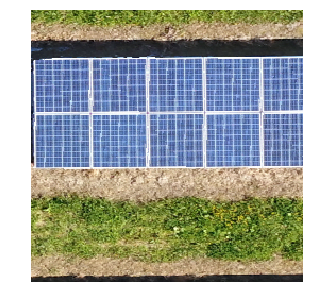

In [78]:
img_f = fnames[32]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

In [80]:
get_y_fn(img_f)

PosixPath('solar_seg/train_masks/00541.png')

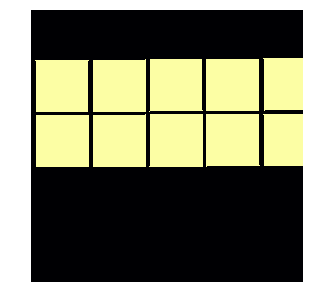

In [81]:
mask = open_mask(get_y_fn(img_f), div=True)
mask.show(figsize=(5,5), alpha=1, cmap = 'inferno')

In [82]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([256, 256]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [0]:
size = src_size//2
bs=64

In [0]:
class MySegmentationLabelList(SegmentationLabelList):
  def open(self, fn): return open_mask(fn, div=True)

class MySegmentationItemList(ImageItemList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = MySegmentationLabelList,False

In [0]:
def get_data(sz, bs):
  src = (MySegmentationItemList.from_folder(path_img)
#        .random_split_by_pct(.01)
         .no_split()
        .label_from_func(get_y_fn, classes=['background','solar_module'])
        .add_test(fnames_test)
        )
  data = (src.transform(get_transforms(flip_vert=True), size=sz, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
  return data

In [0]:
data = get_data(256, 16)

In [166]:
data

ImageDataBunch;

Train: LabelList
y: MySegmentationLabelList (101 items)
[ImageSegment (1, 256, 256), ImageSegment (1, 256, 256), ImageSegment (1, 256, 256), ImageSegment (1, 256, 256), ImageSegment (1, 256, 256)]...
Path: solar_seg/train_images
x: MySegmentationItemList (101 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: solar_seg/train_images;

Valid: LabelList
y: MySegmentationLabelList (0 items)
[]...
Path: solar_seg/train_images
x: MySegmentationItemList (0 items)
[]...
Path: solar_seg/train_images;

Test: LabelList
y: EmptyLabelList (100 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: MySegmentationItemList (100 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: solar_seg/train_images

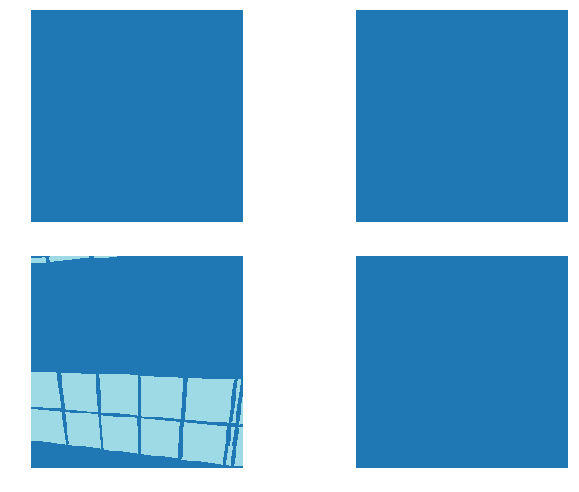

In [167]:
data.show_batch(2, figsize=(10,7), alpha=1)

In [0]:
metrics = partial(dice, iou=True)
wd = 1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


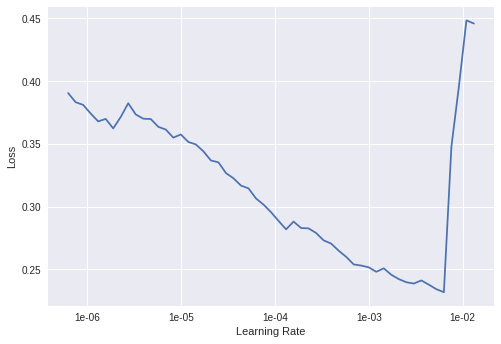

In [92]:
learn.lr_find(); learn.recorder.plot()

In [170]:
learn.fit_one_cycle(12, 1e-4)

In [171]:
learn.unfreeze()
learn.fit_one_cycle(12, slice(1e-5,1e-4))

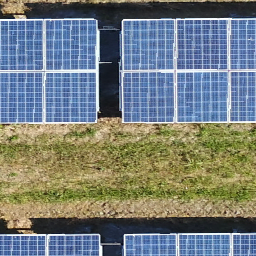

In [175]:
data.test_ds.x[1]

In [0]:
a,b,c = learn.predict(data.test_ds.x[1])

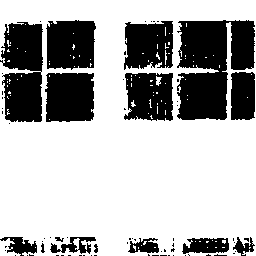

In [177]:
a